In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

# random seed 설정
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# 토큰화

## SentencePiece 모델 학습

In [2]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

vocab_size = 8000
prefix = 'ko_' + str(vocab_size)

data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'

if not os.path.exists(f"{model_dir}/{prefix}.model"):
    spm.SentencePieceTrainer.train(
        f"--input={corpus_file} --model_prefix={prefix}" + # 말뭉치 & 저장 이름
        f" --vocab_size={vocab_size + 7}" + # 사전 크기
        " --model_type=bpe" +             # 토큰화 방식
        " --max_sentence_length=999999" + # 문장 최대 길이
        " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
        " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
        " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
        " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
        " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

## SentencePiece 모델 불러오기 

In [3]:
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/{prefix}.model")

True

In [4]:
# 특수 토큰 7개를 제외한 모든 토큰 vocab_list에 저장
vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

In [5]:
print('사전내 단어 개수:', len(vocab_list))

사전내 단어 개수: 8000


# pre-train 데이터셋 준비하기

## 마스킹 함수 create_pretrain_mask 정의 

In [6]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: 한 문장에 들어가는 tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []
    for index, token in enumerate(tokens):
        if token == '[CLS]' or token == '[SEP]':
            # 특수 토큰인 [CLS]와 [SEP]은 무시
            continue
        if len(cand_idx) > 0 and not token.startswith(u'\u2581'):
            # 이전 토큰과 같은 단어로 취급
            cand_idx[-1].append(index)
        else:
            # cand_idx에 단어 추가
            cand_idx.append([index])

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = []
    for word_idx in cand_idx:
        # 이미 mask_cnt만큼 마스킹 했다면 중지
        if len(mask_lms) >= mask_cnt:
            break
        # word_idx의 모든 토큰을 추가할때 mask_cnt을 넘기면 다음 단어로 넘어감
        if len(mask_lms) + len(word_idx) > mask_cnt:
            continue
        
        # 단어 마스킹 방법 고르기
        dice = random.random()

        # 같은 단어에 속하는 토큰은 같은 마스킹 방법 적용
        for index in word_idx:
            # 80% 확률로 마스킹 토큰으로 대체
            if dice < 0.8:
                masked_token = "[MSK]"
            # 10% 확률로 원래 토큰 유지
            elif dice < 0.9:
                masked_token = tokens[index]
            # 10% 확률로 랜덤 토큰으로 대체
            else:
                masked_token = random.choice(vocab_list)

            # 마스킹한 토큰의 위치와 원래 토큰 저장하기
            mask_lms.append({'index': index, 'label': tokens[index]})
            # 토큰 마스킹
            tokens[index] = masked_token
            
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

## create_pretrain_mask 함수 테스트

In [7]:
# 입력 문장 생성
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens, "\n")

mask_cnt = int(len(tokens) * 0.15)

# 문장 마스킹
tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

# 마스킹된 결과
print("tokens")
print(tokens, "\n")

# 마스킹한 토큰
print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[MSK]', '[MSK]', '[MSK]', '▁삼', '십', '▁전', '▁둘', '째', '번', '[MSK]', '[MSK]', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '프', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '[MSK]', '[MSK]', '[MSK]', '▁눈', '물이', '▁흘', '러', '[MSK]', '[MSK]', '[MSK]', '▁목', '에', '▁모', '주', '▁한', '잔'

## NSP pair 생성 함수  create_pretrain_instances 정의
- `trim_tokens`
    - 문장의 길이를 일정 길이(max_seq)에 맞추는 함수
- `create_pretrain_instances`
    - 여러 문장이 담긴 doc을 받아 MLM과 NSP처리
    - 반환 타입
        - tokens
            - MLM과 NSP 처리된 시퀀스
        - segment
            - segment embedding에 전달할 세그먼트 구분 정보
            - 문장 A와 문장 B이 어디까지인지 표시
        - is_next
            - NSP 타겟 데이터
            - 문장 연결이 매끄러운지의 여부
                - 1: True(isNext)
                - 2: False(notNext)
        - mask_idx
            - MLM 타겟 데이터
            - 마스킹된 토큰의 인덱스 리스트
        - mask_label
            - MLM 타겟 데이터
            - 마스킹된 토큰의 정답 토큰 리스트

In [8]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        # 문장 길이가 max_seq 안으로 들어오면 종료
        if total_length <= max_seq:
            break
        
        # 두 시퀀스 중 가장 긴 시퀀스의 토큰 제거
        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [9]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    :param vocab: SentencePieceProcess(), 토큰화 객체
    :param doc: MLM과 NSP 데이터로 만들 document, 각 문장마다 토큰화된 sentence 리스트
    :param n_seq: 최종 시퀀스의 최대 길이
    :param mask_prob: 각 토큰의 마스킹 확률
    :vocab_list: 특수 토큰을 제외한 사전 내 토큰 리스트
    :return instances: MLM과 NSP 처리된 학습 데이터셋, 위의 markdown 참조
    """
    # 특수 토큰 [CLS]과 [SEP]는 필수이므로 길이 제한에서 제외
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        
        # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  
            # tokens_a와 tokens_b로 분리하기 위해 경계 고르기
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
                
            # tokens_a 가져오기
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
                
            # tokens_b 가져오기
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            # 50% 확률로 notNext로 변환
            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
                
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            
            # Masked Language Model 데이터 생성
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

## create_pretrain_instances 테스트

In [10]:
# 테스트용 데이터
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

# 데이터 토큰화
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [11]:
# NSP 데이터 생성
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# NSP 데이터 생성 결과
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '[MSK]', '[MSK]', '▁전', '▁둘', '째', '[MSK]', '▁오', '십', '[MSK]', '▁오', '랜', '만에', '▁받아', '보', '는', '[MSK]', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '[MSK]', '[MSK]', '[MSK]', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [14, 15, 16, 19, 22, 29, 60, 61, 62], 'mask_label': ['▁삼', '십', '▁전', '▁번', '▁전', '▁십', '▁날', '이었', '어']}
{'tokens': ['[CLS]', '[MSK]', '[MSK]', '▁돌아', '가는', '▁길', '▁난', '▁문', '득', '▁떠', '올', '라', '▁아내', '의', '[MSK]', '[MSK]', '[MSK]', '▁거', '칠', '어', '만', '▁가는', '▁희', '박', '한', '▁숨', '소', '리가', '[SEP]', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔

## pre-train 데이터셋 생성 함수 make_pretrain_data 정의 

In [12]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ 
    pretrain 데이터 생성 
    :param vocab: SentencePieceProcess(), 토큰화 객체
    :param in_file: pretrain에 사용될 데이터 들어있는 파일 위치
    :param out_file: 생성된 pretrain 데이터가 저장될 파일 위치
    :param n_seq: 최종 시퀀스의 최대 길이
    :param mask_prob: 각 토큰의 마스킹 확률
    """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)    
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

## make_pretrain_data를 통해 pretrain 데이터셋 생성

In [13]:
pretrain_json_path = os.getenv('HOME') + '/aiffel/bert_pretrain/data/bert_pre_train.json'

if not os.path.exists(pretrain_json_path):
    make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [14]:
# 데이터셋 크기 확인
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
print("데이터 수:", total)

데이터 수: 918189


# pretrain 데이터셋 불러오기

In [15]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

## 데이터셋 로드

In [16]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128)

  0%|          | 0/918189 [00:00<?, ?it/s]

/tmp/ipykernel_544/2049745891.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_544/2049745891.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

# BERT 모델 구현

## 마스크 생성 함수

In [17]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

## GELU 활성화 함수 

In [18]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

## weights 초기화 함수

In [19]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

## Config 관리 클래스
- 학습시 사용하는 하이퍼 파라미터를 JSON 파일에서 불러올 수 있는 파이썬 딕셔너리

In [20]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

## Token Embedding 레이어

In [21]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

## Position Embedding 레이어

In [22]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

## Scaled Dot-Product Attention 레이어

In [23]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

## Multi-Head Attention 레이어

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out_m = self.attention(Q_m, K_m, V_m, attn_mask_m) # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out_m, [0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, self.n_head * self.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

## Position-Wise Feed Forward 레이어

In [25]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

## Encoder 레이어

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        # Multi-Head Self Attention
        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        # Feed Forward
        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        # Multi-Head Self Attention
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        # Feed Forward
        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

## BERT

In [27]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        # 패딩 마스크 생성
        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)
        
        # 입력 데이터 임베딩
        enc_embed = self.get_embedding(enc_tokens, segments)

        # 인코더 레이어
        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        # NSP
        logits_cls = enc_out[:,0] # [CLS]위치에 해당하는 토큰만 반환
        # MLM
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

## NSP 헤더
- NSP 과제 해결을 위한 추가적인 헤더
- 출력 노드가 2개
    - MLM처럼 SparseCategoricalCrossentropy로 손실값을 계산하기 위함
    - binary classification을 class가 2개인 multi-class classification처럼 바꾼 것

In [28]:
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

## 모델 생성 함수

In [29]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

# 모델 pretrain

## 손실 함수

In [30]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

## 정확도 함수

In [31]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

## 학습률 스케쥴러

In [32]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

## 하이퍼 파라미터 설정

In [33]:
config = Config({"d_model": 128, 
                 "n_head": 4, 
                 "d_head": 32, 
                 "dropout": 0.1, 
                 "d_ff": 1024, 
                 "layernorm_epsilon": 0.001, 
                 "n_layer": 2, 
                 "n_seq": 256, 
                 "n_vocab": 0, 
                 "i_pad": 0})

config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()

## 모델 생성

In [37]:
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 128), (None, 1717888     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            16768       bert[0][0]                 

## 옵티마이저 설정 및 모델 컴파일

In [38]:
epochs = 10
batch_size = 512

# learning rate scheduler
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), 
                        optimizer=optimizer, 
                        metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 17940


## 모델 pretrain

In [39]:
# callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", 
                                                  monitor="mlm_lm_acc", 
                                                  verbose=1, save_best_only=True, 
                                                  mode="max", 
                                                  save_freq="epoch", 
                                                  save_weights_only=True)

# train
history = pre_train_model.fit(pre_train_inputs,   # inputs
                              pre_train_labels, # labels
                              epochs=epochs,            # epochs
                              batch_size=batch_size,    # batch size
                              callbacks=[save_weights]  # callback
                              )

Epoch 1/10
1794/1794 [==============================] - 1015s 564ms/step - loss: 17.4740 - nsp_loss: 0.5778 - mlm_loss: 16.8962 - nsp_acc: 0.6953 - mlm_lm_acc: 0.0779

Epoch 00001: mlm_lm_acc improved from -inf to 0.07793, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 2/10
1794/1794 [==============================] - 1013s 565ms/step - loss: 15.2131 - nsp_loss: 0.5231 - mlm_loss: 14.6899 - nsp_acc: 0.7503 - mlm_lm_acc: 0.1259

Epoch 00002: mlm_lm_acc improved from 0.07793 to 0.12590, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 3/10
1794/1794 [==============================] - 1014s 565ms/step - loss: 13.8594 - nsp_loss: 0.5173 - mlm_loss: 13.3421 - nsp_acc: 0.7534 - mlm_lm_acc: 0.1543

Epoch 00003: mlm_lm_acc improved from 0.12590 to 0.15433, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 4/10
1794/1794 [==============================] - 1015s 566ms/step - loss: 12.4840 - nsp_loss: 0.5144 -

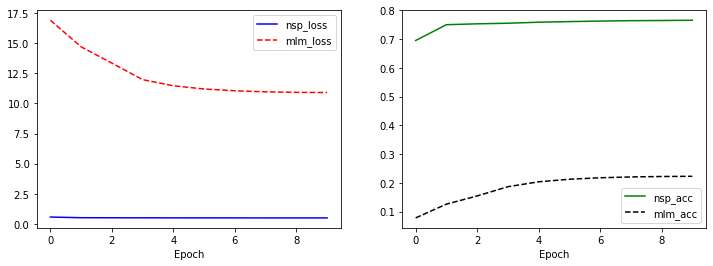

In [40]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# 회고
- pre-trained 모델을 만들기 위한 방법이 매우 방대하다
    - pre-train 이후 specific task를 학습하기 위한 헤더를 붙일 수 있는 모델 구조
    - 어떤 specific task든 빠르고 좋은 성능으로 학습할 수 있도록 pre-train하는 방법
    - 어떤 task도 모델이 받아내도록 도와주는 입력 데이터 template
    - 다양한 task를 가진 데이터셋
- pre-trained 모델은 만들어진 걸 쓰는것이 답이다
    - 그나마 작은 모델임에도 한 epoch에 16분
    - [Gugugo](https://github.com/jwj7140/Gugugo) 개발자가 왜 1epoch 학습후 결과를 올렸는지 이해하게됨